# A simple notebook demonstrating how to find SWOT swaths that intersect a given lat-lon bounding box

This notebook is based on an example taken from the [SWOT-OpenToolkit](https://github.com/SWOT-community/SWOT-OpenToolkit) developed by Jinbo Wang (Texas A&M).

This short notebook is useful for sanity checking when you're trying to find swaths in a specific region.

In [ ]:
"""
Find the SWOT satellite fly-by time through a bounding box. 
The time will have uncertainty of tens of seconds to minutes depending on 
the size of the bounding box.

Make sure download the two shapefile associated with the SWOT orbit data from the aviso website. You can use the included script to download the data.

    bash download_swot_orbit.sh

Usage:
    python find_swot_passes_science.py -sw_corner -130.0 35.0 -ne_corner -125.0 40.0 -output_filename /tmp/test.png

1st Author: Jinbo Wang
Date: 2021-07-21
Adapted by: Tatsu Monkman
Date: 2025-01-24
Midified by: Ryan Shìjié Dù
Date: 2026-02-12
"""

import geopandas as gpd
import pandas as pd
import shapely.geometry as geometry
from datetime import timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, LineString, Point
import numpy as np
import os,argparse

# To begin, download the shapefiles containing the lat/lon coordinates along SWOT swaths

### Key points:
- The geopandas compressed "shapefiles" containing the orbital tracks for the two SWOT orbital configurations can be downloaded from AVISO using the <code>download_swot_orbit_data.sh</code> bash script located in the <code>src</code> directory. 
- The compressed calval orbit shapefile is named <code>shp_calval_swath.zip</code> and corresponds to the orbital track that SWOT followed during the calibration/validation phase of the mission (~90 days from March 2023 to July 2023). 
- The compressed science orbit shapefile is named <code>sph_science_swath.zip</code> and corresponds to the orbital track that SWOT transitioned to after the calibration/validation phase was completed in July 2023 and currently follows now.
- Note that this script also downloads the nadir paths, which only includes the path of SWOT's nadir (i.e. doesn't include the KaRIn swaths to the left/right). The nadir paths are smaller

### WARNING
NOTE THAT THE CALVAL NADIR FILE IS STILL MISLABELED ON AVISO (June 26, 2025).The file online is listed as "shp_science_nadir.zip" when it should be "sph_science_nadir". We will need to edit the scripts below and the download_swot_orbit.sh script when they correct this.


In [2]:
# "calval" and "science" refer to SWOT's initial 1-day repeat calibration orbit and the 21-day repeat science orbit, respectively
# orbit = "science"
orbit = "calval"

# download the two shapefile associated with the SWOT orbit data from the aviso website
if os.path.exists("../orbit_data/sph_science_nadir.zip") is False or os.path.exists("../orbit_data/sph_science_swath.zip") is False:
    print("Please download the two shapefiles associated with the SWOT orbit data from the aviso website using the included script.\n")
    print("run bash download script using:")
    print("bash download_swot_orbit_data.sh\n")
    exit()
    
elif orbit == "calval":
    # Load the calval orbit shapefile
    gdf_orbit = gpd.read_file("../orbit_data/sph_calval_swath.zip")
    
elif orbit == "science":
    # Load the science orbit shapefile
    gdf_orbit = gpd.read_file("../orbit_data/sph_science_swath.zip")


/home/ryansjdu/SWOT_download/.pixi/envs/default/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /vsizip/../orbit_data/sph_calval_swath.zip/swot_calval_orbit_june2015-v2_swath.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


# Next, specify the lat-lon limits for the bounding box over which you want to pull swaths

### Lat-lon boxes can just be specified by defining their Southwest / Northeast corners.
I just specify the coordinates of each corner using <code>[deg East, deg North]</code>

Some example domains:
<python>
    
    # Global 
    sw_corner = [-180.0, -90.0]
    ne_corner = [180.0, 90.0]
        
    # Hawaii
    corner = [-167, 0.0]
    corner = [-135.0, 45.0]
    
    # West Greenland
    sw_corner = [-56.55, 68.32]
    ne_corner = [-50., 72.5]

    # small Agulhas
    sw_corner = [10.0,  -42.0] # [degE, degN]
    ne_corner = [18.0, -36.0] # [degE, degN]
    
    # big Agulhas
    sw_corner = [5.0, -50.0]
    ne_corner = [30.0, -30.0]

    # California CAL/VAL roughly
    sw_corner = [-127, 32.5]
    ne_corner = [-124, 38.5]


</python>



### Let's find the orbits that cross the Kuroshio region as an example

- First, we need to define the bounding box ("<code>bbox</code>" below) as a shapely object that geopandas can understand
- Next we can use the orbit shapefile to find the paths that intersect the "bbox" using geopandas magic

In [3]:
# Rough East of Japan domain (Kuroshio-ish)
sw_corner = [-127, 32.5]
ne_corner = [-124, 38.5]

# Define the bounding box as a shapely object using our lat lon coordinates
bbox = geometry.box(sw_corner[0], sw_corner[1], ne_corner[0], ne_corner[1])
# Get the overlapping segments using geopandas magic
overlapping_segments = gdf_orbit[gdf_orbit.intersects(bbox)]

# Plot the bounding box + overlapping SWOT orbits as a sanity check

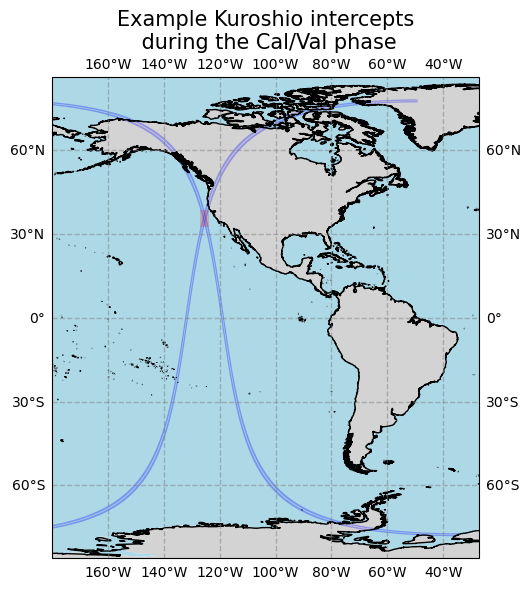

In [4]:
# Set up plot
subplot_kw = {'projection': ccrs.PlateCarree()}

fig, axs = plt.subplots(1,1,figsize=(50,6),subplot_kw=subplot_kw)

axs.set_title("Example Kuroshio intercepts\n during the Cal/Val phase",fontsize=15)

axs.add_feature(cfeature.COASTLINE.with_scale('10m'))
axs.add_feature(cfeature.LAND, edgecolor='none', facecolor='lightgray')
axs.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='lightblue')
# Plot the shapefile data
#gdf.plot(ax=ax, transform=ccrs.PlateCarree())
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=1, color='gray', alpha=0.5, linestyle='--')

overlapping_segments.plot(ax=axs,alpha=0.3,color="b")

b = gpd.GeoSeries(bbox)
b.plot(ax=axs,color="r",alpha=0.2)


#axs.set_extent([-65, -10, 55, 90], crs=ccrs.PlateCarree())

plt.tight_layout()

plt.show()
plt.close()



## You can look at the "overlapping_segments" object to get a sense for what kind of information we have:

In [5]:
print(overlapping_segments)

    ID_PASS START_TIME                                           geometry
18       13   10:13:10  MULTIPOLYGON (((-180 -74.75549, -180 -74.20044...
37       26   21:17:20  MULTIPOLYGON (((-180 76.73818, -180 77.22219, ...


Note that "START_TIME" is just a general estimate of the start time of a given pass, and may be out of date...